In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sys, os, time, math
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import h5py, pickle, subprocess
import umap, scipy
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date

In [2]:
######### Parameters of transitions between "macroscopic" states ##########
nstates_final = 7
max_states = 100
n_components_tMat = 15
trajl = 40 # Trajectory Length for morphodynamical trajectory analysis
wellsInfo = 'Awells'
conditions = ['B2'] # LIGANDS or CONDITIONS
tmSet = ['EGF2']

In [3]:
nConditions = len(tmSet) # Total number of Ligand Conditions
#os.environ['OMP_NUM_THREADS'] = '1'; os.environ['MKL_NUM_THREADS'] = '1'

today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = sysName+'_tlen'+str(trajl)+'_'+date2day

# Indices for the ligands 
inds_tmSet = [i for i in range(nConditions)]
inds_tmSet = np.array(inds_tmSet).astype(int)
nfovs = 1
#fovs = [i for i in range(1, nfovs + 1)]
fovs = 2
fovs = np.array(fovs).astype(int)
dateSet = ['']
pathSet = ['/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/']
imagingSet = [0 for i in range(nConditions)]
modelList = [None]*(nfovs*(nConditions))
modelList_conditions = np.zeros(nfovs*(nConditions)).astype(int)

In [6]:
i = 0
icond = 0
for cond in conditions:
    modelList_conditions[i] = icond
    modelList[i] = pathSet[imagingSet[icond]]+sysName+'_'+cond+'_'+str(fovs)+dateSet[imagingSet[icond]]
    #print("Models: ",modelList[i])
    i = i + 1
    icond = icond + 1

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [7]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print('loaded '+objFile+' with '+str(modelSet[i].cells_indSet.size)+' cells')
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models,i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_2.obj with 103219 cells


In [8]:
# Total number of frames (image snapshots) in one condition per FOVs
nframes = 193 
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*nframes/100.; sframe = math.ceil(sframe)
eframe = 98.5*nframes/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(nframes)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [9]:
for i in indgood_models:
    ncells = np.zeros(nframes)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(nframes):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [11]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)

# get cell counts
n_conds = len(tmSet)
inds_tmSet_models = np.zeros(nmodels).astype(int)
inds_imagingSet_models = np.zeros(nmodels).astype(int)
i = 0
icond = 0
for cond in conditions:
    inds_tmSet_models[i] = inds_tmSet[icond] # Assign indices "tmSet" to all FOVs
    inds_imagingSet_models[i] = imagingSet[icond]
    icond = icond + 1

In [12]:
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0 #just replace with zeros for now? Not sure best...

In [13]:
nfeat_com = 3
Xf_com0 = np.zeros((0, nfeat_com))
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [14]:
wctm = cellTraj.Trajectory() # import Trajectory object 
nfeat = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, nfeat))
indtreatment = np.array([])
indcellSet = np.array([])
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
        # Indices for each model for later access using them
        indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
        indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [15]:
varCutOff = 10
from sklearn.decomposition import PCA #we will use the sklearn package (intended for ease of use over performance/scalability)
pca = PCA(n_components = varCutOff) #n_components specifies the number of principal components to extract from the covariance matrix
pca.fit(Xf) #builds the covariance matrix and "fits" the principal components
Xpca = pca.transform(Xf) #transforms the data into the pca representation
nPCs = Xpca.shape[1]

wctm.Xpca = Xpca
wctm.pca = pca
for i in indgood_models:
    if inds_imagingSet_models[i] == 0:
        indsf = np.where(indtreatment == i)[0]
        modelSet[i].Xpca = Xpca[indsf, :]

indgood_models = indgood_models[np.where(inds_imagingSet_models[indgood_models] == 0)[0]]

In [16]:
self = wctm
wctm.trajl = trajl
all_trajSet = [None]*nmodels
for i in indgood_models:
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

tracked cell 103200, 1 tracks, 103200 left
tracked cell 103169, 1 tracks, 103000 left
tracked cell 103088, 133 tracks, 100500 left
tracked cell 102798, 5 tracks, 88600 left
tracked cell 102785, 2 tracks, 88000 left
tracked cell 102700, 182 tracks, 84700 left
tracked cell 102669, 16 tracks, 83500 left
tracked cell 102614, 14 tracks, 80800 left
tracked cell 102605, 1 tracks, 80500 left
tracked cell 102570, 8 tracks, 78700 left
tracked cell 102532, 65 tracks, 77500 left
tracked cell 102501, 11 tracks, 76200 left
tracked cell 102461, 66 tracks, 74800 left
tracked cell 102432, 24 tracks, 73700 left
tracked cell 101265, 2 tracks, 69300 left
tracked cell 100374, 1 tracks, 68900 left
tracked cell 99699, 1 tracks, 68600 left
tracked cell 98800, 1 tracks, 67800 left
tracked cell 97946, 1 tracks, 66900 left
tracked cell 97584, 3 tracks, 66500 left
tracked cell 97333, 1 tracks, 66300 left
tracked cell 95271, 16 tracks, 65000 left
tracked cell 94634, 1 tracks, 64300 left
tracked cell 94559, 11 trac

In [17]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory 
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length + 1):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

In [18]:
# Single-cell trajectories over the dimensionally reduced cell features
Xpcat = np.zeros((0, pca.n_components_*trajl + nfeat_com*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
cellinds0_traj = np.array([])
cellinds1_traj = np.array([])
cb_ratio_traj = np.array([])
for i in indgood_models:
    print('building trajectory data for model {}...'.format(i))
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window
    # modelSet[i].traj = modelSet[i].get_traj_segments(trajl)
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xpca[modelSet[i].traj, :] 
    datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xpca.shape[1]*trajl)
    datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xpcat = np.append(Xpcat, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    indframes = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame index at the start of the snippet
    indframes_traj = np.append(indframes_traj, indframes) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories
    cellinds0 = modelSet[i].traj[:, 0] # Cell indices at the start of snippets 
    cellinds0_traj = np.append(cellinds0_traj, cellinds0)
    cellinds1 = modelSet[i].traj[:, -1] # Cell indices at the end of snippets 
    cellinds1_traj = np.append(cellinds1_traj, cellinds1)
    cb_ratio_traj = np.append(cb_ratio_traj, modelSet[i].Xf[cellinds1, 77])

cellinds0_traj = cellinds0_traj.astype(int)
cellinds1_traj = cellinds1_traj.astype(int)

building trajectory data for model 0...


In [19]:
neigen = Xpcat.shape[1] # If embedded trajectories aren't UMAP'ed 
inds_conditions = [None]*n_conds
for imf in range(n_conds):
    indmodels = np.intersect1d(indgood_models, np.where(inds_tmSet_models == imf)[0])
    indstm = np.array([])
    for imodel in indmodels:
        indtm = np.where(indtreatment_traj == imodel)
        indstm = np.append(indstm, indtm)
    inds_conditions[imf] = indstm.astype(int).copy() # Condition (Model) specific trajectory snippet indices: Add up all FOVs
    #print(inds_conditions[imf])

In [20]:
##### Cluster single-cell trajectories of a given snippet length by using KMeans from deeptime 
from deeptime.clustering import KMeans
n_clusters = 200
model = KMeans(n_clusters = n_clusters,  # Place 200 cluster centers
               init_strategy = 'kmeans++',  # kmeans++ initialization strategy
               max_iter = 0,  # don't actually perform the optimization, just place centers
               fixed_seed = 13)
################################ Initial clustering ###############################
clustering = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 

model.initial_centers = clustering.cluster_centers
model.max_iter = 5000
clusters = model.fit(Xpcat).fetch_model() # If embedded trajectories aren't UMAP'ed 
wctm.clusterst = clusters

In [21]:
knn = 50
for i in indgood_models:
    modelSet[i].trajectories = all_trajSet[i].copy()

In [22]:
def get_trajectory_steps(self, inds=None, traj=None, Xtraj=None,
                         get_trajectories=True, nlag=1): # traj and Xtraj should be indexed same
    if inds is None:
        inds = np.arange(self.cells_indSet.size).astype(int)
    if get_trajectories:
        self.get_unique_trajectories(cell_inds=inds)
    if traj is None:
        traj = self.traj
    if Xtraj is None:
        x = self.Xtraj
    else:
        x = Xtraj
    trajp1 = self.get_traj_segments(self.trajl + nlag) # Get trajectory snippets @ snippet_length + nlag
    # Reversed index array inds_nlag is created to keep indices every nlag steps
    inds_nlag = np.flipud(np.arange(self.trajl + nlag - 1, -1, -nlag)).astype(int) # keep indices every nlag
    trajp1 = trajp1[:, inds_nlag]
    ntraj = trajp1.shape[0]
    
    neigen = Xpcat.shape[1]
    x0 = np.zeros((0, neigen))
    x1 = np.zeros((0, neigen))
    inds_trajp1 = np.zeros((0, 2)).astype(int)
    # Matching segments of trajectories and then appending the corresponding feature data from Xpcat to two arrays, 'x0' and 'x1'
    for itraj in range(ntraj):
        test0 = trajp1[itraj, 0:-1] # [0:self.trajl]
        test1 = trajp1[itraj, 1:] # [1:self.trajl+1]
        # traj[:, None] == test0[np.newaxis, :]: This expression compares each segment in 'traj' with 'test0'.
        # The use of [:, None] and [np.newaxis, :] reshapes the arrays for broadcasting, allowing element-wise
        # comparison between each segment in 'traj' and the segment 'test0'. 
        # .all(-1): This checks if all elements in a segment are equal, resulting in a boolean array where each
        # element represents whether a segment in 'traj' matches 'test0'.
        # .any(-1): This determines if there is any match in 'traj' for 'test0'. 'res0' is a boolean array indicating
        # which trajectories in 'traj' match 'test0'
        res0 = (traj[:, None] == test0[np.newaxis, :]).all(-1).any(-1)
        res1 = (traj[:, None] == test1[np.newaxis, :]).all(-1).any(-1)
        if np.sum(res0) == 1 and np.sum(res1) == 1: # If at least one matching array in 'traj' for both 'test0' & 'test1' 
            indt0 = np.where(res0)[0][0] # Collect indices where above matching happens
            indt1 = np.where(res1)[0][0] # Collect indices where above matching happens
            x0 = np.append(x0, np.array([Xpcat[indt0, :]]), axis = 0)
            x1 = np.append(x1, np.array([Xpcat[indt1, :]]), axis = 0)
            inds_trajp1 = np.append(inds_trajp1, np.array([[indt0, indt1]]), axis = 0)
        if itraj%100 == 0:
            sys.stdout.write('matching up trajectory '+str(itraj)+'\n')
    self.Xtraj0 = x0
    self.Xtraj1 = x1
    self.inds_trajp1 = inds_trajp1

In [24]:
dxs = np.zeros((nmodels, n_clusters, neigen))
x0set = np.zeros((0, neigen))
x1set = np.zeros((0, neigen))
inds_trajsteps_models = np.array([]).astype(int)
for i in indgood_models:
    print('getting flows from model: '+str(i))
    indstm = np.where(indtreatment_traj == i)[0]
    if indstm.size > 0:
        modelSet[i].Xtraj = Xpcat[indstm, 0:neigen]
        indstm_model = indstm - np.min(indstm) # index in the model
        if inds_imagingSet_models[i] == 1:
            modelSet[i].get_trajectory_steps(inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :],
                                             Xtraj=modelSet[i].Xtraj[indstm_model, :])
        else:
            get_trajectory_steps(modelSet[i], inds=None, get_trajectories=False, traj=modelSet[i].traj[indstm_model, :], 
                                 Xtraj=modelSet[i].Xtraj[indstm_model, :])
        x0 = modelSet[i].Xtraj0
        x1 = modelSet[i].Xtraj1
        x0set = np.append(x0set, x0, axis=0)
        x1set = np.append(x1set, x1, axis=0)
        inds_trajsteps_models = np.append(inds_trajsteps_models, np.ones(x0.shape[0])*i)
        dx = x1 - x0
        for iclust in range(n_clusters):
            xc = np.array([clusters.cluster_centers[iclust, :]])
            dmatr = wctm.get_dmat(modelSet[i].Xtraj[modelSet[i].inds_trajp1[:, -1], :], xc) #get closest cells to cluster center
            indr = np.argsort(dmatr[:, 0])
            indr = indr[0:knn]
            cellindsr = modelSet[i].traj[[modelSet[i].inds_trajp1[indr, -1]], -1]
            dxs[i, iclust, :] = np.mean(dx[indr, :], axis=0)

getting flows from model: 0
matching up trajectory 0
matching up trajectory 100
matching up trajectory 200
matching up trajectory 300
matching up trajectory 400
matching up trajectory 500
matching up trajectory 600
matching up trajectory 700
matching up trajectory 800
matching up trajectory 900
matching up trajectory 1000
matching up trajectory 1100
matching up trajectory 1200
matching up trajectory 1300
matching up trajectory 1400
matching up trajectory 1500
matching up trajectory 1600
matching up trajectory 1700
matching up trajectory 1800
matching up trajectory 1900
matching up trajectory 2000
matching up trajectory 2100
matching up trajectory 2200
matching up trajectory 2300
matching up trajectory 2400
matching up trajectory 2500
matching up trajectory 2600
matching up trajectory 2700
matching up trajectory 2800
matching up trajectory 2900
matching up trajectory 3000
matching up trajectory 3100
matching up trajectory 3200
matching up trajectory 3300
matching up trajectory 3400
matc

In [25]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size = "5%", pad = 0.05)
    cbar = fig.colorbar(mappable, cax = cax)
    plt.sca(last_axes)
    return cbar

In [26]:
############################ Generate transition matrix ############################
centers_minima  = clusters.cluster_centers.copy()
nclusters = clusters.cluster_centers.shape[0]

# Assign "new data" to cluster centers
indc0 = clusters.transform(x0set).astype(int) # Indices of cluster centers where each snippets of 'x0set' belong 
indc1 = clusters.transform(x1set).astype(int) # Indices of cluster centers where each snippets of 'x1set' belong
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
graph = csr_matrix(P > 0.)
n_components, labels = connected_components(csgraph=graph, directed=False, return_labels=True)
unique, counts = np.unique(labels, return_counts=True)
icc = unique[np.argmax(counts)]
indcc = np.where(labels == icc)[0]
centers_minima = centers_minima[indcc, :]

############### Using pyEmma for assignments only #################
import pyemma.coordinates as coor
clusters_minima = coor.clustering.AssignCenters(centers_minima, metric='euclidean')
######## Now clusters_minima will have attribute clusters_minima.clustercenters ########
nclusters = clusters_minima.clustercenters.shape[0]
indc0 = clusters_minima.assign(x0set)
indc1 = clusters_minima.assign(x1set)
wctm.get_transitionMatrixDeeptime(indc0, indc1, nclusters)
P = wctm.Mt.copy()

import pygpcca as gp
gpcca = gp.GPCCA(P, eta=None, z='LM', method='brandts')

neigen_umap = 0 # In this case
# Dump Transition Matrix for further analysis 
tmFileName = 'tMat_'+sysName+'_'+str(trajl)+'_'+date2day+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.joblib'
with open(tmFileName, 'wb') as fp:
     dump(P, fp, compress = 'zlib')

In [27]:
# Find Eigenvalues and Eigenvectors of the transition matrix "P"
H = .5*(P + np.transpose(P)) + .5j*(P - np.transpose(P))
w, v = np.linalg.eig(H)  
w = np.real(w)
indsort = np.argsort(w)
# Sorted eigenvalues & eigenvalues 
w = w[indsort] # Eigen Values
v = v[:, indsort] # Eigen Vectors
ncomp = n_components_tMat # Keep last "ncomp" eigenvectors
vr = np.multiply(w[-ncomp:], np.real(v[:, -ncomp:]))
vi = np.multiply(w[-ncomp:], np.imag(v[:, -ncomp:]))
vkin = np.append(vr, vi, axis = 1) # Eigenvectors (real & imaginary)
#plt.plot(w)

In [28]:
from sklearn.cluster import KMeans

In [29]:
################### Get kinetics of cell (macro or coarse) state transitions #####################
def get_kinetic_states_module(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                              max_states = 20, cluster_ninit = 10):
       nstates_good = 0
       nstates = nstates_initial
       vkinFit = vkin
       while nstates <= max_states:
            clusters_v = KMeans(n_clusters = nstates, init = 'k-means++',
                                n_init = cluster_ninit, max_iter = 5000, 
                                random_state = 0)
            clusters_v.fit(vkinFit) 
            stateSet = clusters_v.labels_
            state_probs = np.zeros(nstates)
            statesc, counts = np.unique(stateSet, return_counts = True)
            state_probs[statesc] = counts/np.sum(counts)
            print(np.sort(state_probs))
            nstates_good = np.sum(state_probs > pcut_final)
            print('{} states initial, {} states final'.format(nstates, nstates_good))
            print(nstates, "Current states", nstates_good, "Good states")
            nstates = nstates + 1
            if nstates_good >= nstates_final:
               break
       pcut = np.sort(state_probs)[-(nstates_final)] #nstates
       states_plow = np.where(state_probs < pcut)[0]
       # Assign (micro)states to predetermined state centers aka "macrostates" with probabilities less than 'pcut'
       for i in states_plow:
           indstate = np.where(stateSet == i)[0]
           for imin in indstate:
               dists = wctm.get_dmat(np.array([vkinFit[imin, :]]), vkinFit)[0] #closest in eigenspace
               dists[indstate] = np.inf
               ireplace = np.argmin(dists)
               stateSet[imin] = stateSet[ireplace]
       slabels, counts = np.unique(stateSet, return_counts = True)
       s = 0
       stateSet_clean = np.zeros_like(stateSet)
       for slabel in slabels:
           indstate = np.where(stateSet == slabel)[0]
           stateSet_clean[indstate] = s
           s = s + 1
       stateSet = stateSet_clean
       if np.max(stateSet) > nstates_final:
          print("returning ", np.max(stateSet)," states", nstates_final, "requested")
       return stateSet, nstates_good  

In [30]:
# Module to optimize pcut_final that shows the best clustering onto 7 states 
def get_kinetic_states(self, vkin, nstates_final, nstates_initial = None, pcut_final = .01,
                       max_states = 20, cluster_ninit = 10):
       if nstates_initial is None:
          nstates_initial = nstates_final
       nstates_good = 0
       while nstates_good < nstates_final or nstates_good > nstates_final:
                 stateSet, nstates_good = get_kinetic_states_module(wctm, vkin, nstates_final, 
                                                                     nstates_initial = nstates_initial, 
                                                                     pcut_final = pcut_final,
                                                                     max_states = max_states,
                                                                     cluster_ninit = cluster_ninit)
                 print("pcut_final = ",pcut_final)
                 pcut_final = pcut_final - 0.001 

       return stateSet

In [31]:
pcut_final = 0.075 # For EGF - Well 1
get_kstates = True
stateCenters = clusters_minima.clustercenters # Centers of microstates (fine-grain states) 
if get_kstates:
   stateSet = get_kinetic_states(wctm, vkin, nstates_final,
                                 nstates_initial = None, pcut_final = pcut_final, 
                                 max_states = max_states, cluster_ninit = 10)
   nstates = np.unique(stateSet).size
   objFile = 'stateSet_'+figid+'_nS'+str(nstates)+'.joblib'
   states_object = [clusters_minima, stateSet]
   with open(objFile, 'wb') as fpStates:
      dump(states_object, fpStates, compress = 'zlib')
else:
   objFile = 'stateSet_'+figid+'_nS'+str(nstates_initial)+'.joblib'
   with open(objFile, 'rb') as fpStates:
       states_object = load(fpStates)
   clusters_minima = states_object[0]
   stateSet = states_object[1]
   nstates = np.unique(stateSet).size

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 0.735]
9 states initial, 3 states final
9 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 4 states final
12 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 4 states final
14 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 3 states final
15 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 4 states final
16 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 3 states final
17 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 3 states final
18 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 3 states final
19 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 4 states final
20 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 2 states final
21 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 2 states final
22 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 3 states final
23 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 3 states final
24 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 2 states final
27 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 2 states final
30 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 2 states final
31 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 2 states final
33 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 3 states final
39 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 2 states final
40 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 3 states final
43 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 2 states final
44 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 3 states final
46 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 2 states final
47 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 2 states final
49 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 2 states final
51 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 2 states final
55 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 1 states final
56 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 1 states final
61 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 1 states final
66 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 2 states final
67 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 2 states final
69 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 0 states final
70 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 0 states final
75 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 1 states final
78 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 1 states final
79 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 1 states final
84 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 0 states final
85 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 0 states final
93 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 0 states final
94 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 0 states final
97 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.075
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 4 states final
12 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 5 states final
16 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 5 states final
18 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 5 states final
20 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 4 states final
21 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 3 states final
27 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 2 states final
30 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 3 states final
40 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 3 states final
43 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 2 states final
44 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 3 states final
46 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 2 states final
47 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 2 states final
51 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 2 states final
55 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 1 states final
61 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 2 states final
67 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 2 states final
69 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 0 states final
75 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 1 states final
78 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 1 states final
79 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 1 states final
84 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 0 states final
85 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 0 states final
93 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.074
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 4 states final
12 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 5 states final
16 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 5 states final
18 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 5 states final
20 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 4 states final
21 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 3 states final
27 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 2 states final
30 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 3 states final
40 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 3 states final
43 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 2 states final
44 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 3 states final
46 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 2 states final
47 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 2 states final
51 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 2 states final
55 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 1 states final
61 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 2 states final
67 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 2 states final
69 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 0 states final
75 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 1 states final
78 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 1 states final
79 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 1 states final
84 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 0 states final
85 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 0 states final
93 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.073
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 4 states final
12 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 5 states final
16 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 5 states final
18 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 5 states final
20 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 4 states final
21 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 3 states final
27 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 2 states final
30 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 3 states final
40 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 3 states final
43 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 2 states final
44 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 3 states final
46 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 2 states final
47 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 2 states final
51 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 2 states final
55 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 1 states final
61 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 2 states final
67 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 2 states final
69 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 0 states final
75 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 1 states final
78 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 1 states final
79 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 1 states final
84 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 0 states final
85 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 0 states final
93 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.072
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 4 states final
12 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 5 states final
16 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 5 states final
18 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 5 states final
20 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 4 states final
21 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 3 states final
24 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 3 states final
27 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 2 states final
30 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 3 states final
40 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 3 states final
43 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 2 states final
44 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 3 states final
46 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 2 states final
47 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 2 states final
51 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 2 states final
55 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 1 states final
61 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 2 states final
67 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 2 states final
69 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 1 states final
74 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 0 states final
75 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 1 states final
78 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 1 states final
79 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 0 states final
81 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 1 states final
83 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 1 states final
84 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 0 states final
85 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 0 states final
93 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.071
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 3 states final
44 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 4 states final
47 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06999999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 3 states final
44 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 4 states final
47 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06899999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 3 states final
44 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 4 states final
47 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06799999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 3 states final
44 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 4 states final
47 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Cur

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06699999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 4 states final
15 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 4 states final
17 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 4 states final
22 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 4 states final
23 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 4 states final
24 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 2 states final
25 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 2 states final
26 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 3 states final
31 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 3 states final
33 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 2 states final
34 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 4 states final
37 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 3 states final
44 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 3 states final
45 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 4 states final
47 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 2 states final
48 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 2 states final
50 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 2 states final
53 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 2 states final
56 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 2 states final
58 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 3 states final
60 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 1 states final
70 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 1 states final
73 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 0 states final
77 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 0 states final
80 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 0 states final
82 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 0 states final
88 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06599999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 5 states final
15 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 6 states final
17 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 5 states final
22 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 5 states final
23 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 5 states final
24 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 4 states final
25 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 4 states final
26 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 4 states final
31 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 4 states final
33 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 4 states final
34 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 5 states final
37 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 4 states final
44 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 4 states final
45 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 5 states final
47 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 3 states final
48 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 3 states final
50 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 3 states final
53 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 3 states final
56 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 3 states final
58 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 4 states final
60 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 2 states final
70 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good state

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 2 states final
73 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 1 states final
77 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 2 states final
80 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 1 states final
82 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 1 states final
88 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06499999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.005 0.075 0.08  0.085 0.735]
9 states initial, 4 states final
9 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 5 states final
15 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 6 states final
17 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 5 states final
22 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 5 states final
23 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 5 states final
24 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 4 states final
25 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 4 states final
26 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 4 states final
31 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 4 states final
33 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 4 states final
34 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 5 states final
37 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 4 states final
44 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 4 states final
45 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 5 states final
47 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 3 states final
48 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 3 states final
50 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 3 states final
53 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 3 states final
56 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 3 states final
58 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 4 states final
60 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 2 states final
70 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 2 states final
73 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 1 states final
77 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 2 states final
80 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 1 states final
82 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 1 states final
88 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06399999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 5 states final
15 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 6 states final
17 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 5 states final
22 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 5 states final
23 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 5 states final
24 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 4 states final
25 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 4 states final
26 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 4 states final
31 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 4 states final
33 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 4 states final
34 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 5 states final
37 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 4 states final
44 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 4 states final
45 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 5 states final
47 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 3 states final
48 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 3 states final
50 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 3 states final
53 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 3 states final
56 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 3 states final
58 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 4 states final
60 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 2 states final
70 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 2 states final
73 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Cur

/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 1 states final
77 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 2 states final
80 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 1 states final
82 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 1 states final
88 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.06299999999999999
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.07

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 5 states final
15 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 6 states final
17 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 5 states final
22 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 5 states final
23 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 5 states final
24 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 4 states final
25 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 4 states final
26 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 4 states final
31 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 4 states final
33 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 4 states final
34 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 5 states final
37 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 4 states final
44 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 4 states final
45 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 5 states final
47 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 3 states final
48 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 3 states final
50 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 3 states final
53 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 3 states final
56 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 3 states final
58 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 4 states final
60 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 2 states final
70 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 2 states final
73 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 1 states final
77 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 2 states final
80 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 1 states final
82 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 1 states final
88 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.061999999999999986
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.0

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 5 states final
15 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 6 states final
17 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.03
 0.07  0.075 0.075 0.09  0.15  0.415]
18 states initial, 6 states final
18 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015
 0.035 0.075 0.075 0.075 0.085 0.21  0.37 ]
19 states initial, 6 states final
19 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.015 0.025
 0.03  0.05  0.07  0.075 0.085 0.095 0.185 0.305]
20 states initial, 6 states final
20 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.015
 0.02  0.025 0.03  0.07  0.07  0.075 0.075 0.18  0.365]
21 states initial, 6 states final
21 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.025 0.03  0.045 0.045 0.05  0.065 0.075 0.075 0.15  0.36 ]
22 states initial, 5 states final
22 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.055 0.065 0.075 0.08  0.17  0.36 ]
23 states initial, 5 states final
23 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.015 0.02  0.025 0.025 0.04  0.04  0.06  0.065 0.07  0.085 0.17  0.31 ]
24 states initial, 5 states final
24 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015
 0.015 0.02  0.025 0.025 0.03  0.03  0.035 0.045 0.06  0.065 0.065 0.155
 0.35 ]
25 states initial, 4 states final
25 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.05  0.055 0.06  0.065 0.065
 0.16  0.32 ]
26 states initial, 4 states final
26 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.03  0.045 0.055 0.06  0.07
 0.075 0.19  0.295]
27 states initial, 4 states final
27 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.015 0.02  0.025 0.025 0.035 0.035 0.045 0.05  0.055 0.06
 0.105 0.11  0.135 0.205]
28 states initial, 4 states final
28 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.015 0.02  0.025 0.025 0.03  0.04  0.04  0.05  0.055
 0.06  0.06  0.11  0.145 0.235]
29 states initial, 3 states final
29 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.04
 0.045 0.05  0.06  0.07  0.185 0.305]
30 states initial, 3 states final
30 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.025 0.025 0.04
 0.045 0.05  0.06  0.065 0.075 0.16  0.3  ]
31 states initial, 4 states final
31 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.03  0.03  0.045 0.05  0.055 0.055 0.15  0.33 ]
32 states initial, 2 states final
32 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.03
 0.03  0.035 0.035 0.045 0.045 0.065 0.075 0.1   0.3  ]
33 states initial, 4 states final
33 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.02  0.02  0.025 0.025
 0.025 0.035 0.04  0.04  0.05  0.055 0.065 0.065 0.12  0.285]
34 states initial, 4 states final
34 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02  0.025
 0.025 0.03  0.04  0.045 0.05  0.055 0.06  0.085 0.105 0.12  0.175]
35 states initial, 4 states final
35 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.02  0.02  0.025
 0.025 0.025 0.03  0.04  0.045 0.05  0.055 0.055 0.095 0.1   0.105 0.185]
36 states initial, 4 states final
36 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.03  0.035 0.035 0.045 0.055 0.06  0.065 0.09  0.09  0.115
 0.135]
37 states initial, 5 states final
37 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02
 0.02  0.025 0.025 0.025 0.025 0.035 0.04  0.045 0.055 0.06  0.085 0.11
 0.11  0.18 ]
38 states initial, 4 states final
38 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02
 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.045 0.045 0.045 0.06  0.075
 0.095 0.11  0.13 ]
39 states initial, 4 states final
39 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04  0.06  0.06
 0.07  0.075 0.105 0.125]
40 states initial, 4 states final
40 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04  0.045
 0.045 0.055 0.085 0.105 0.205]
41 states initial, 3 states final
41 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.04  0.04  0.04
 0.045 0.055 0.06  0.09  0.105 0.2  ]
42 states initial, 3 states final
42 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.045 0.055 0.055 0.07  0.09  0.125 0.17 ]
43 states initial, 4 states final
43 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.035
 0.035 0.04  0.055 0.06  0.065 0.07  0.11  0.19 ]
44 states initial, 4 states final
44 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03  0.03
 0.04  0.045 0.05  0.055 0.055 0.065 0.085 0.115 0.125]
45 states initial, 4 states final
45 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.04  0.055 0.055 0.06  0.07  0.08  0.105 0.155]
46 states initial, 4 states final
46 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.025
 0.025 0.03  0.035 0.04  0.055 0.06  0.065 0.07  0.07  0.115 0.125]
47 states initial, 5 states final
47 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.025
 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.05  0.05  0.065 0.11  0.165]
48 states initial, 3 states final
48 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.04  0.045 0.05  0.05  0.06  0.075 0.11
 0.12 ]
49 states initial, 3 states final
49 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.055 0.055 0.065
 0.095 0.125]
50 states initial, 3 states final
50 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.02  0.025 0.03  0.04  0.04  0.05  0.055 0.055 0.055
 0.07  0.11  0.13 ]
51 states initial, 3 states final
51 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.045 0.05
 0.06  0.085 0.105 0.135]
52 states initial, 3 states final
52 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.02  0.02  0.025 0.025 0.025 0.025 0.025 0.025 0.025 0.03  0.04  0.04
 0.04  0.06  0.065 0.11  0.165]
53 states initial, 3 states final
53 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.025 0.03  0.03  0.035 0.035 0.04  0.045
 0.055 0.055 0.06  0.06  0.085 0.12 ]
54 states initial, 2 states final
54 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.03  0.035 0.04  0.04
 0.045 0.05  0.06  0.06  0.07  0.085 0.11 ]
55 states initial, 3 states final
55 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.015
 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.03  0.04  0.04
 0.04  0.05  0.055 0.06  0.06  0.065 0.075 0.1  ]
56 states initial, 3 states final
56 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.035 0.035 0.04  0.05  0.055 0.06  0.06  0.08  0.12 ]
57 states initial, 2 states final
57 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.035 0.035 0.045 0.045 0.055 0.06  0.065 0.115 0.135]
58 states initial, 3 states final
58 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.03  0.035 0.035 0.04  0.045 0.05  0.055 0.08  0.085 0.1  ]
59 states initial, 3 states final
59 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.02  0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.035 0.04  0.045 0.065 0.08  0.09  0.14 ]
60 states initial, 4 states final
60 Current states 4 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025
 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.035 0.04  0.05  0.07  0.07
 0.095]
61 states initial, 3 states final
61 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05  0.06
 0.105 0.13 ]
62 states initial, 2 states final
62 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.03  0.03  0.035 0.04  0.04  0.04  0.045 0.05
 0.05  0.1   0.11 ]
63 states initial, 2 states final
63 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04
 0.04  0.055 0.105 0.145]
64 states initial, 2 states final
64 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.03  0.03  0.03  0.04  0.045 0.045
 0.055 0.06  0.06  0.08  0.115]
65 states initial, 2 states final
65 Current states 2 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.035 0.035
 0.04  0.05  0.055 0.06  0.075 0.105]
66 states initial, 2 states final
66 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.03  0.035
 0.035 0.035 0.04  0.045 0.07  0.085 0.105]
67 states initial, 3 states final
67 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.03  0.04  0.04  0.05  0.06  0.06  0.09  0.1  ]
68 states initial, 2 states final
68 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02
 0.025 0.04  0.04  0.045 0.045 0.05  0.07  0.095 0.095]
69 states initial, 3 states final
69 Current states 3 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.03
 0.03  0.035 0.035 0.035 0.04  0.055 0.055 0.06  0.065 0.075]
70 states initial, 2 states final
70 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.02  0.02  0.025 0.025
 0.025 0.025 0.025 0.025 0.025 0.025 0.035 0.04  0.04  0.105 0.105]
71 states initial, 2 states final
71 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.03  0.03  0.03  0.04  0.04  0.05  0.055 0.06  0.06  0.095]
72 states initial, 1 states final
72 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.025 0.03  0.035 0.035 0.035 0.035 0.035 0.06  0.06  0.065
 0.09 ]
73 states initial, 2 states final
73 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05  0.05
 0.07  0.085]
74 states initial, 2 states final
74 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.02  0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.035 0.04  0.04
 0.05  0.07  0.07 ]
75 states initial, 2 states final
75 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.035 0.035 0.04  0.04  0.045
 0.045 0.05  0.06  0.09 ]
76 states initial, 1 states final
76 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.025 0.03  0.03  0.03  0.03  0.035 0.035 0.035
 0.04  0.05  0.05  0.055 0.065]
77 states initial, 1 states final
77 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.025 0.025 0.03  0.03  0.03  0.03
 0.045 0.045 0.05  0.06  0.07  0.085]
78 states initial, 2 states final
78 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.035 0.04  0.045 0.06  0.07  0.085]
79 states initial, 2 states final
79 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.025
 0.03  0.035 0.045 0.045 0.05  0.06  0.065 0.065]
80 states initial, 2 states final
80 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.03  0.03
 0.03  0.03  0.035 0.04  0.04  0.04  0.055 0.055 0.07 ]
81 states initial, 1 states final
81 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.03
 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.06  0.065]
82 states initial, 1 states final
82 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.025 0.025 0.025 0.025 0.025 0.03  0.03  0.045 0.055 0.07  0.095]
83 states initial, 2 states final
83 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.025 0.025 0.03  0.035 0.035 0.04  0.04  0.04  0.07  0.09 ]
84 states initial, 2 states final
84 Current states 2 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.035 0.045 0.055 0.06  0.06
 0.07 ]
85 states initial, 1 states final
85 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.025 0.03  0.035 0.04  0.04  0.045 0.045 0.05
 0.05  0.06 ]
86 states initial, 0 states final
86 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.02  0.02  0.02  0.02  0.025 0.03  0.035 0.04  0.045 0.045
 0.05  0.06  0.105]
87 states initial, 1 states final
87 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.04
 0.05  0.05  0.05  0.065]
88 states initial, 1 states final
88 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015
 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.025 0.025 0.025 0.03  0.035
 0.04  0.04  0.05  0.06  0.09 ]
89 states initial, 1 states final
89 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.015 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.035 0.035
 0.035 0.04  0.045 0.05  0.055 0.06 ]
90 states initial, 0 states final
90 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.025 0.025
 0.025 0.03  0.035 0.045 0.05  0.05  0.105]
91 states initial, 1 states final
91 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025 0.025 0.03  0.03
 0.035 0.035 0.04  0.04  0.045 0.05  0.05  0.05 ]
92 states initial, 0 states final
92 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.02  0.025 0.03  0.03  0.035 0.045 0.045 0.06  0.07 ]
93 states initial, 1 states final
93 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.025
 0.025 0.025 0.025 0.03  0.03  0.035 0.045 0.05  0.06  0.075]
94 states initial, 1 states final
94 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02  0.02
 0.025 0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.045 0.06 ]
95 states initial, 0 states final
95 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.02  0.02
 0.02  0.025 0.025 0.03  0.03  0.035 0.035 0.035 0.04  0.045 0.05  0.055]
96 states initial, 0 states final
96 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015 0.015 0.02
 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.035 0.04  0.04  0.05
 0.075]
97 states initial, 1 states final
97 Current states 1 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.025 0.025 0.025 0.025 0.03  0.03  0.03  0.04  0.05
 0.05  0.06 ]
98 states initial, 0 states final
98 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015 0.015 0.015 0.015
 0.02  0.02  0.02  0.02  0.02  0.025 0.025 0.025 0.03  0.035 0.035 0.04
 0.045 0.05  0.06 ]
99 states initial, 0 states final
99 Current states 0 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.01  0.01  0.01
 0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.01  0.015
 0.015 0.015 0.02  0.02  0.02  0.025 0.025 0.03  0.03  0.03  0.03  0.04
 0.04  0.05  0.05  0.05 ]
100 states initial, 0 states final
100 Current states 0 Good states
returning  8  states 7 requested
pcut_final =  0.060999999999999985
[0.005 0.005 0.005 0.005 0.005 0.18  0.795]
7 states initial, 2 states final
7 Current states 2 Good states
[0.005 0.005 0.005 0.01  0.015 0.1   0.125 0.735]
8 states initial, 3 states final
8 Current states 3 Good states
[0.005 0.005 0.005 0.005 0.005 0.0

/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible 

[0.005 0.005 0.005 0.005 0.01  0.015 0.095 0.14  0.175 0.545]
10 states initial, 4 states final
10 Current states 4 Good states
[0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.08  0.085 0.085 0.675]
11 states initial, 4 states final
11 Current states 4 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.07  0.085 0.085 0.1   0.61 ]
12 states initial, 5 states final
12 Current states 5 Good states
[0.005 0.005 0.005 0.01  0.01  0.01  0.015 0.02  0.08  0.08  0.13  0.27
 0.36 ]
13 states initial, 5 states final
13 Current states 5 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.015 0.04  0.075 0.08  0.085
 0.13  0.54 ]
14 states initial, 5 states final
14 Current states 5 Good states
[0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.03  0.06  0.065 0.075
 0.105 0.3   0.31 ]
15 states initial, 6 states final
15 Current states 6 Good states
[0.005 0.005 0.005 0.005 0.005 0.01  0.01  0.015 0.025 0.045 0.07  0.075
 0.08  0.08  0.155 0.41 ]
16 states initial, 6 states final
16 Current states 6 Good states


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/celltraj/lib/python3.9/site-packages/threadpoolctl.py:546: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more


[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.01  0.015 0.05  0.06  0.065
 0.065 0.075 0.09  0.17  0.365]
17 states initial, 7 states final
17 Current states 7 Good states
pcut_final =  0.059999999999999984


/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj/jcTrajectory_CP.py:2459: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(y)


In [32]:
n_states = nstates
state_centers_minima = np.zeros((n_states, neigen))
for i in range(n_states):
    indstate = np.where(stateSet == i)[0]
    state_centers_minima[i, :] = np.median(stateCenters[indstate, :], axis=0)

state_labels = np.array(list(string.ascii_uppercase))[0:n_states]

In [33]:
# Consider frames only in the range of 24+-6, i.e., 18-30 hours -> frame numbers: 72-120
# Note: images are collected at the interval of 15 minutes for 48 hours
fl = 72 
fu = 120 #fu = nframes
indstw = np.where(np.logical_and(indframes_traj < fu, indframes_traj > fl))[0] # Indices 

In [34]:
# Get Cross correlations & respective frame numbers along all single-cell trajectories
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [35]:
# Get cross-correlation values along all single-cell trajectories (sorted as per trajectory length) 
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/decomposeCCtraj_macrostates/'
cc_filename = f"{cc_path}{sysName}_{conditions[0]}_2.dat"
cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

In [ ]:
# Load the objects back from the .npz file
with np.load('ccTrajs_EGF1info.npz', allow_pickle=True) as data:
    cc_vals_model_loaded = data['cc_vals']
    frames_model_loaded = data['frames']
    cc_trajs_model_indc_loaded = data['cc_trajs']

# Now you have the original nested lists back
print(cc_vals_model_loaded)
print(frames_model_loaded)
print(cc_trajs_model_indc_loaded)

In [36]:
# Map trajectory snippets on Macrostates via Microstates
state_order = np.arange(n_states).astype(int)

for i in range(n_conds):
    indstm = inds_conditions[i] # Condition Specific Indices
    indstwm = np.intersect1d(indstm, indstw) # Indices of trajectory snippets within frame range (72 - 120)
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within the given frame range
    ################ Mapping Microstates (Fine-grain) to Macrostates (Coarse-grain) #################
    indc_map_macro = stateSet[clusters_minima.assign(x0)] # Assign Microstates to Macrostates
    # Initialize Dictionary to store Cross-correlation Values of Snippets of Start Frames for each Macrostate 
    cc_values_by_macrostate = {}
    for si in state_order:
        state_label = chr(65 + si)  # Convert state index to the uppercase letters (A, B, C,...)
        cc_values_by_macrostate[state_label] = []
        #print(f'Macrostate: {state_label}')
        ind_map = np.where(indc_map_macro == si)[0] # Indices: Microstates -> Macrostate
        #print(f'x0 indices: {ind_map}')
        indc_map_Xpcat = indstwm[ind_map] # Mapping back to original Xpcat indices Corresponding to a Macrostate 
        #print(f'Xpcat indices: {indc_map_Xpcat}')
        fid_macro_snippet = indframes_traj[indc_map_Xpcat].astype(int) # Map frame indices of snippets onto Macrostates 
        indc_map_fulltraj_snippets = indmodel_traj_snippets[indc_map_Xpcat].astype(int) # Map Indices of Full Trajectory to Snippets 
        #print(f'Start Frame Indices of Snippets: {fid_macro_snippet}')
        ################## Identify the "FULL" trajectory index and locate snippets within it ##################
        for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
            possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_macro_snippet[j])  
            indc_ccvals_traj = possible_indices[0][0]
            #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
            cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
            #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
            cc_values_by_macrostate[state_label].append(cc_vals)
#print(cc_values_by_macrostate)

IndexError: list index out of range

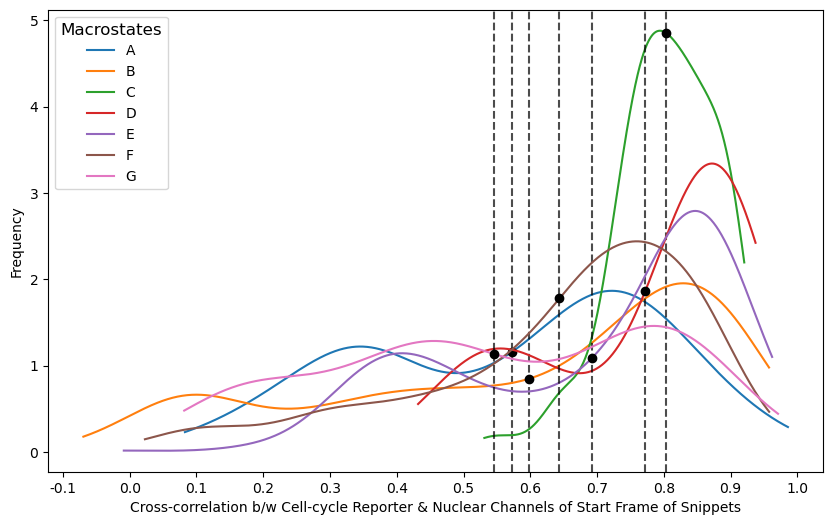

In [34]:
from scipy.stats import gaussian_kde
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each state's distribution
for state, values in cc_values_by_macrostate.items():
    kde = gaussian_kde(values)
    x_range = np.linspace(min(values), max(values), 1000)
    ax.plot(x_range, kde(x_range), label=f'{state}')

    # Highlight the mean value
    mean_x = np.mean(values)
    mean_y = kde(mean_x)
    ax.plot(mean_x, mean_y, 'o', color='k')

    # Add a vertical line for the mean
    ax.axvline(mean_x, color='k', linestyle='--', alpha=0.7)

legend = ax.legend(title='Macrostates')
plt.setp(legend.get_title(), fontsize='large')
ax.set_xlabel('Cross-correlation b/w Cell-cycle Reporter & Nuclear Channels of Start Frame of Snippets')
ax.set_ylabel('Frequency')

# Set major and minor ticks on the x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(ticker.MultipleLocator())

# Format tick labels to a specified number of decimal places
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

# Set grid for minor ticks
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
plt.show()

<Figure size 640x480 with 0 Axes>

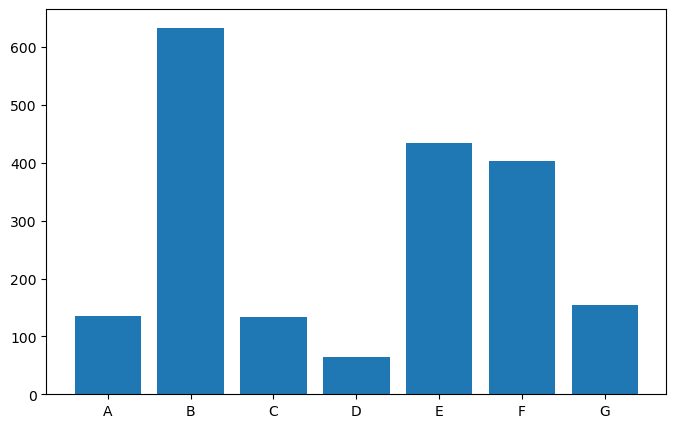

In [35]:
# Map trajectory snippets on the coarse states to generate a histogram 
state_order = np.arange(n_states).astype(int)
macrostates = np.array(state_labels)[state_order]
plt.clf()
plt.figure(figsize = (8, 5))
for i in range(n_conds):
    indstm = inds_conditions[i] # Condition Specific Indices
    indstwm = np.intersect1d(indstm, indstw) # Indices of trajectory snippets within frame range (72 - 120)
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within the frame range
    # Know Indices & calculate (coarse) state probs by Mapping Fine-grain (Microstates) to Coarse-grain (Macrostates)
    indc_micro = clusters_minima.assign(x0) # Microstate cluster indices 
    indc_macro = stateSet[indc_micro] # Assignment of each microstate to the macrostates 
    states_centers, counts = np.unique(indc_macro, return_counts = True) # Counting how many times a macrostate is hit by a microstate 
    plt.bar(macrostates, counts)
plt.show()

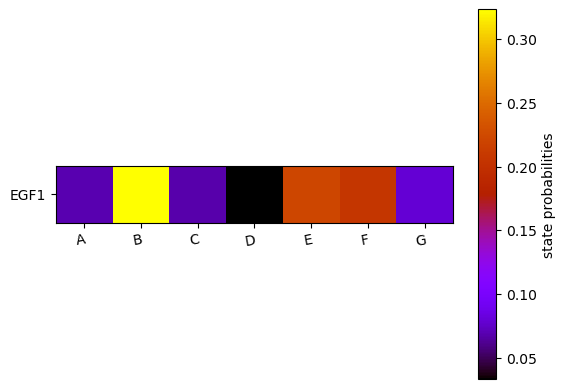

In [36]:
state_probs = np.zeros((n_conds, n_states))
for i in range(n_conds):
    indstm = inds_conditions[i] # Condition Specific Indices of All Trajectories
    indstwm = np.intersect1d(indstm, indstw) # Indices for a given trajectory snippet length
    x0 = Xpcat[indstwm, :] # keep trajectory snippets that are within frame range (72 - 120)
    # Know Indices & calculate (coarse) state probs by Mapping Fine-grain (Microstates) to Coarse-grain (Macrostates)
    indc0 = stateSet[clusters_minima.assign(x0)]  
    statesc, counts = np.unique(indc0, return_counts = True)
    state_probs[i, statesc] = counts/np.sum(counts)

state_order = np.arange(n_states).astype(int)
plt.clf()
plt.imshow(state_probs[:, state_order], cmap=plt.cm.gnuplot)
cbar = plt.colorbar()
cbar.set_label('state probabilities')
# We want to show all ticks...
ax = plt.gca()
ax.set_yticks(np.arange(len(tmSet)))
ax.set_xticks(np.arange(n_states))
ax.set_xticklabels(np.array(state_labels)[state_order])
ax.set_yticklabels(tmSet)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=10, ha="right",rotation_mode="anchor")
plt.pause(.1)

#plt.savefig('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.png')
#np.savetxt('stProbs_'+figid+'_nS'+str(nstates)+'pc'+str(nPCs)+'u'+str(neigen_umap)+wellsInfo+'.dat', state_probs)

In [37]:
"""
wells_flg = 0 # Flag to import data of certain wells combinations
if(wells_flg == 0):
  wellsInfo = 'Awells'
  conditions = ['A1','A2','A3','A4','A5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
elif(wells_flg == 1):
  wellsInfo = 'Bwells'
  conditions = ['B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
else:
  wellsInfo = 'AllWells'
  conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)
  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2',
           'PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']
"""

"\nwells_flg = 0 # Flag to import data of certain wells combinations\nif(wells_flg == 0):\n  wellsInfo = 'Awells'\n  conditions = ['A1','A2','A3','A4','A5','C1','C2','C3'] # LIGANDS (CONDITIONS)\n  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']\nelif(wells_flg == 1):\n  wellsInfo = 'Bwells'\n  conditions = ['B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)\n  tmSet = ['OSM2','EGF2','EGF+TGFB2','TGFB2','PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']\nelse:\n  wellsInfo = 'AllWells'\n  conditions = ['A1','A2','A3','A4','A5','B1','B2','B3','B4','B5','C1','C2','C3'] # LIGANDS (CONDITIONS)\n  tmSet = ['OSM1','EGF1','EGF+TGFB1','TGFB1','PBS1','OSM2','EGF2','EGF+TGFB2','TGFB2',\n           'PBS2','OSM+EGF+TGFB','OSM+EGF','OSM+TGFB']\n"

In [32]:
# Get Macrostate Trajectories with Start Frame Indices 
def get_macrostate_trajectories(frame_id_macro_snippet):
        state_trajectories = []
        current_trajectory = [frame_id_macro_snippet[0]]

        # Iterate through frame indices
        for i in range(1, len(frame_id_macro_snippet)):
           # Check if the current frame index is a continuation of the current trajectory
           if frame_id_macro_snippet[i] == current_trajectory[-1] + 1:
              current_trajectory.append(frame_id_macro_snippet[i])
           else:
              # The current frame index breaks the trend, saves the current trajectory, and starts a new one
              state_trajectories.append(current_trajectory)
              current_trajectory = [frame_id_macro_snippet[i]]

        # Add the last trajectory if not empty
        if current_trajectory:
           state_trajectories.append(current_trajectory)
        # Flatten the list of lists into a single list
        start_frames_macrostate = [frame for trajectory in state_trajectories for frame in trajectory]
        
        return start_frames_macrostate

In [38]:
def get_cdist2d(prob1):
    nx = prob1.shape[0]; ny = prob1.shape[1]
    prob1 = prob1/np.sum(prob1)
    prob1 = prob1.flatten()
    indprob1 = np.argsort(prob1)
    probc1 = np.zeros_like(prob1)
    probc1[indprob1] = np.cumsum(prob1[indprob1])
    probc1 = 1. - probc1
    probc1 = probc1.reshape((nx, ny))
    return probc1